# Bucket Screening - biased sampling


Let $L_i$  be the positive label proportion of the neighbors of the sample i $(0 \leq L_i \leq 1)$,
and $C$ be the total proportion of the positive labels.
We have $N$ samples.
alpha is the target sampling rate (e.g., $\alpha$ = 0.001).

1. Compute the relative probability defined by
  $$ P_i=\left\{
  \begin{array}{@{}ll@{}}
    e^{- \lambda \frac{L_i - C}{1 - C}} & \text{if}\ L_i \geq C \\
    e^{- \lambda \frac{C - L_i}{C}} & \text{if}\  L_i < C
  \end{array}\right.$$

2. Create (non-normalized) cumulative distribution
  $$F_0 = 0$$
  $$F_j = \sum_{i=1}^j P_i$$
  
3. Draw $\alpha N$ independent random numbers $R_k$ from the uniform distribution between $0$ and $F_N$.

4. Choose sample $i$ if any of the random numbers lies in $F_{i-1} <= R_k < F_i$

5. If many samples were chosen twice, iterate Step 2 to Step 5 after removing already chosen samples.

In [158]:
# setup the code
%matplotlib inline

import matplotlib.pyplot as plt
import math
import numpy as np
import numpy.ma as ma
from sklearn import random_projection
from itertools import groupby
from heapq import heappush, heappop
import random
from sklearn import svm
from pylab import rcParams
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.utils import check_random_state

from __future__ import division

# Use seaborn styles for nice-looking plots
import seaborn; seaborn.set()

# define some utility functions
def plotHyperplane(normal, intercept=0, label='', plt=plt):
    """ Plot a hyperplane given a normal and an intercept
    """
    a = -normal[0] / normal[1]
    xx = np.linspace(-10, 10)
    yy = a * xx - (intercept) / normal[1]    
    plt.plot(xx, yy, label=label)    
    return 0

# Hasher
def generateBitString( x ):
    return "".join(['1' if i > 0 else '0' for i in x])

def shuffle_in_unison_inplace(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


class BucketScreening:
    """BucketScreening class"""

    def maxRatio(self, pos, allPoints):
        return max(pos / allPoints, (allPoints - pos) / allPoints)                 

    def posRatio(self, pos, allPoints):
        return pos / allPoints                 
            
    def __init__(self, bits, features, rnd=42, hashes=10, bias=True, uniform=False, mode='pos'):
        self.hashes = hashes
        self.bias = bias
        self.uniform = uniform
        self.bins = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1, 1.01 ]
        self.ratios =  {
            'pos' : self.posRatio,
            'max' : self.maxRatio
        }
        self.mode = mode
        self.rng = check_random_state(rnd) 
        self.rng.seed(rnd)
        
        self.projections = [random_projection.gaussian_random_matrix(bits, features , random_state=self.rng) for variable in range(hashes)]        
        # intercepts
        if bias:
            if uniform:
                self.intercepts = [rng.rand(bits,1) for variable in range(hashes)]                
            else:
                self.intercepts = [rng.randn(bits,1) for variable in range(hashes)]                
    
    def screen(self, X, Y):
        # first project the data #hashes times
        
        if self.bias:
            projected = [np.apply_along_axis( generateBitString, axis=1, arr=np.dot(X, proj.T ) + self.intercepts[idx].T ) for idx, proj in enumerate(self.projections)]        
        else:
            projected = [np.apply_along_axis( generateBitString, axis=1, arr=np.dot(X, proj.T )) for proj in self.projections]        

        # now generate aggregate stats                
        self.hashtable = []
        
        for buckets in projected:
            stats = dict()
            # aggregate the points to compute the stats
            for key in np.unique(buckets):
                # estimate pos ratio        
                qualifying = Y[buckets == key]
                length = qualifying.shape[0] * 1.0
                # Count how many are positive
                pos = qualifying[qualifying == 1].shape[0]
                
                # Compute dominance using the correct mode
                ratio = self.ratios[self.mode](pos, length)
                
                #print(key,ratio,pos,length)
                stats[key] = ratio
            
            self.hashtable.append(stats)
                                
        # Now learn the distribution for each point
        X_filtered = []
        
        for p in range(X.shape[0]):        
            strings = [proj[p] for proj in projected]               
            value = []
            for position, item in enumerate(self.hashtable):                            
                value.append(item[strings[position]])
            X_filtered.append(sum(value) / len(value))
        
        self.X_filtered = np.array(X_filtered)

        #self.hist, self.bins = np.histogram(X_filtered, bins=self.bins)        
        self.hist, self.bins = np.histogram(X_filtered, bins = 10, density=False)                

        # compute C (number of positive points)
        self.C = (Y[Y == 1].shape[0]) / Y.shape[0] * 1.0
        
        
        
    def printAverage(self):
        for key, value in stats.iteritems(): 
            self.ratio[key] = sum(value) / len(value)
        
        
    def plotHistogram(self):
        #print self.bins
        #print self.hist
        width = 0.7 * (self.bins[1] - self.bins[0])
        center = (self.bins[:-1] + self.bins[1:]) / 2
        plt.title('Histogram of point ratio')                    
        #plt.xlim(0.5, 1)    
        plt.bar(center, self.hist, align='center', width=width)
        #plt.xlim(min(self.bins), max(self.bins))        
        #plt.savefig('histogram.pdf')
        plt.ylabel('Occurences')
        plt.xlabel(self.mode + ' Ratio')
        plt.show()                
        print "C = %f" % (self.C)
        
    def filter(self, X, Y, min=0.9, max=1):            
        ''' Filter points within range '''
        
        return (X[(self.X_filtered >= min) & (self.X_filtered < max)], 
                Y[(self.X_filtered >= min) & (self.X_filtered < max)])      
        
    def sampleFilter(self, X, Y, lambdaParameter = 1, alpha=0.2, rnd=42):
        """ Filter based on sample probability"""
        
        # compute C (number of positive points)
        C = (Y[Y == 1].shape[0]) / Y.shape[0] * 1.0
        toSample = int(alpha * Y.shape[0])
        
        def computePi(X_input):

            self.rng.seed(rnd)

            # compute P_i
            # first project the data
            if self.bias:
                projected = [np.apply_along_axis( generateBitString, axis=1, arr=np.dot(X_input, proj.T ) + self.intercepts[idx].T ) for idx, proj in enumerate(self.projections)]        
            else:
                projected = [np.apply_along_axis( generateBitString, axis=1, arr=np.dot(X_input, proj.T )) for proj in self.projections]        

            # now iterate through projected bitstrings and pick up labels that are used
            # compute the score for each point
            
            P_i = []
        
            for p in range(X_input.shape[0]):        
                strings = [proj[p] for proj in projected]               
                value = []
                for position, item in enumerate(self.hashtable):                            
                    value.append(item[strings[position]])
                L_i = sum(value) / len(value)
                if (L_i >= C):
                    p = math.exp(- lambdaParameter * ((L_i - C) / (1 - C)))                
                else:
                    p = math.exp(- lambdaParameter *  ((C - L_i) / C))

                P_i.append(p)

            P_i = np.array(P_i)

            return P_i
            

        # the points to use
        X_ret = np.array([])
        Y_ret = np.array([])
                    
        # We need to iterate the following    
 
        # Step 1
        P_i = computePi(X)

        while(toSample > 0):    
            
            F_i = np.cumsum(P_i)            
            F_i = np.insert(F_i, 0, 0)

            # Here we compute the cummulative sum
            F_n = np.sum(P_i)        

            # mask defines points to use
            mask = ma.make_mask(np.zeros(Y.shape[0]), shrink=False)
            
            for x in range(0, toSample):
                # we take the number .. iff Choose sample i if any of the random number lies in F_{i-1} <= R_k < F_i
                # so find which bucket it falls into
                R_k = self.rng.uniform(0, F_n)

                for i in range(1, F_i.shape[0]):
                    if(F_i[i-1] <= R_k and R_k < F_i[i]):
                        # we take you
                        mask[i - 1] = True
                        break

            # if we have too few points go back to step 2
            # first store all selected points in the output
            toSample = toSample - X[mask].shape[0]

            if Y_ret.shape[0] == 0:
                X_ret = X[mask]
                Y_ret = Y[mask]
            else:
                X_ret = np.concatenate((X_ret,X[mask]))
                Y_ret = np.concatenate((Y_ret,Y[mask]))

            # the points we can look at now, are all the ones we have not looked at before
            X = X[~mask]
            Y = Y[~mask]
            
            P_i = P_i[~mask]
                
        # print mask[mask==True].shape[0]
        
        return (X_ret,Y_ret)
    
    def display(self,X,Y,alpha=0.1):
        """This function plots 4 paramater variations"""
        # train svm on the entire data
        entire = svm.SVC(kernel='linear', C=1.0)
        entire.fit(X,Y)  

        ## from pylab import rcParams
        rcParams['figure.figsize'] = 20, 5
        f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=True, sharex=True)

        plt.suptitle(r'Sampling with $\alpha$ {0} '.format(alpha), fontsize=14)

        # plot the random svm 

        ax1.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired, label='Points', vmin=0, vmax=1)
        ax1.set_title('Entire Dataset')    

        #ax2.scatter(reducedX[:, 0], reducedX[:, 1], c=reducedY, zorder=10, cmap=plt.cm.Paired, label='Points')
        #ax2.set_title('Mixed Buckets')    

        #sets = [[0.73, 0.86],[0.6,0.85],[0.85,0.90],[0.9, 0.95]]
        sets = [0.01,1,20,100]

        plotHyperplane(entire.coef_[0],entire.intercept_[0],plt=ax1,label='Entire Dataset')

        count = 0;
        for plot in (ax2, ax3, ax4, ax5):
            plotHyperplane(entire.coef_[0],entire.intercept_[0],plt=plot,label='Entire Dataset')
            s = 0
            try:
                reducedX, reducedY = screen.sampleFilter(X,Y, lambdaParameter=sets[count], alpha=alpha, rnd = 42)
                plot.scatter(reducedX[:, 0], reducedX[:, 1], c=reducedY, zorder=10, cmap=plt.cm.Paired, label='Points', vmin=0, vmax=1)

                reduced = svm.SVC(kernel='linear', C=1.0)#LinearSVC(C=1)#kernel='linear')
                reduced.fit(reducedX, reducedY)
                s = reduced.score(X,Y)
                #print "%s %s %s" % (str(sets[count]), reduced.coef_[0],reduced.intercept_[0])
                plotHyperplane(reduced.coef_[0],reduced.intercept_[0],plt=plot,label=r'Our Method $\lambda$ ' + str(sets[count]))        

            except (ValueError, IndexError) as e:
                raise NameError(e)
                #print "error ({0})".format( e)
                #pass    

            print('Our Method lambda %4s   %f with %2d points' % (str(sets[count]), s ,reducedX.shape[0] ))    

            plot.set_title(r'Our Method $\lambda$ ' + str(sets[count]))    
            plot.scatter(entire.support_vectors_[:, 0], entire.support_vectors_[:, 1], s=80,
                        facecolors='none', zorder=10, label='Support vector', vmin=0, vmax=1)
            plot.legend(loc='lower left')

            count = count + 1

        ax1.set_xlim([-10,10])
        ax1.set_ylim([-10,10])    
        ax1.legend(loc='lower left')
        #ax1.show()
        print('Entire Dataset  %f with %d points (%d sv)'% (entire.score(X,Y),X.shape[0], entire.support_vectors_.shape[0]))
    
    def showPoints(self, X, Y):
        """Display the points as they fall into the buckets"""
        
        # train svm on the entire data
        entire = svm.SVC(kernel='linear', C=1.0)
        entire.fit(X,Y)  
     
        binIndex = np.digitize(self.X_filtered, self.bins)
        
        ## from pylab import rcParams
        rcParams['figure.figsize'] = 20, 5
        f, ax = plt.subplots(2, 5, sharey=True, sharex=True)

        count = 1;
        for plot in ax.ravel():
            reducedX = X[binIndex == count]
            reducedY = Y[binIndex == count]
            plot.scatter(reducedX[:, 0], reducedX[:, 1], c=reducedY, cmap=plt.cm.Paired, label='Points', vmin=0, vmax=1)
            plot.set_title(r'bin ' + str(self.bins[count]))    

            # Support Vectors
            #plot.scatter(entire.support_vectors_[:, 0], entire.support_vectors_[:, 1], s=80,
            #facecolors='none', zorder=10, label='Support vector', vmin=0, vmax=1)

            #plotHyperplane(entire.coef_[0],entire.intercept_[0],plt=plot,label='Entire Dataset')

            count = count + 1
        
            plot.set_xlim([-10,10])
            plot.set_ylim([-10,10])                  
            
            if count >= self.bins.shape[0]:
                break
    

In [159]:
# Now generate some random points
rng = np.random.RandomState(42)
n_samples_1 = 100
n_samples_2 = 100
X = np.r_[2 * rng.randn(n_samples_1, 2) - [2,2],
          1* rng.randn(n_samples_2, 2) + [2, 2]]
Y = np.array([0] * (n_samples_1) + [1] * (n_samples_2))

# Permute X and Y
(X,Y) = shuffle_in_unison_inplace(X,Y)

#rom sklearn.preprocessing import normalize
# = normalize(X, axis=1, norm='l2')

from sklearn import preprocessing

# = preprocessing.scale(X)

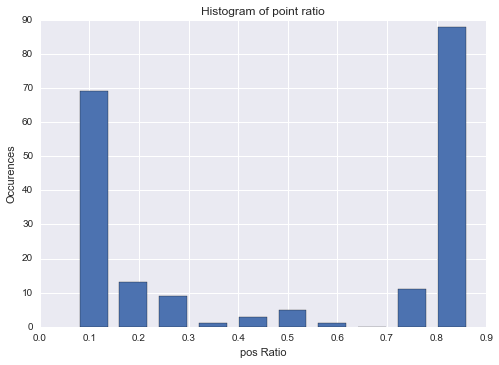

C = 0.500000


In [160]:
screen = BucketScreening(1, X.shape[1], hashes=10, bias=True, uniform=True, mode='pos')

# 6, 100
# good 5 bits, hashes 100

#%time 
screen.screen(X,Y)

screen.plotHistogram()

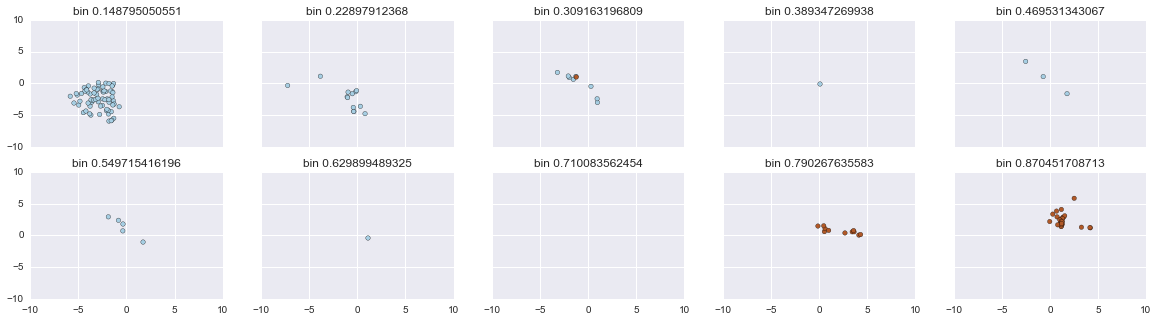

In [161]:
# show the distribution of the points in the buckets
screen.showPoints(X,Y)

Taking only points from 0.309000 -> 0.790270 (in total 21), yields accuracy 0.985000


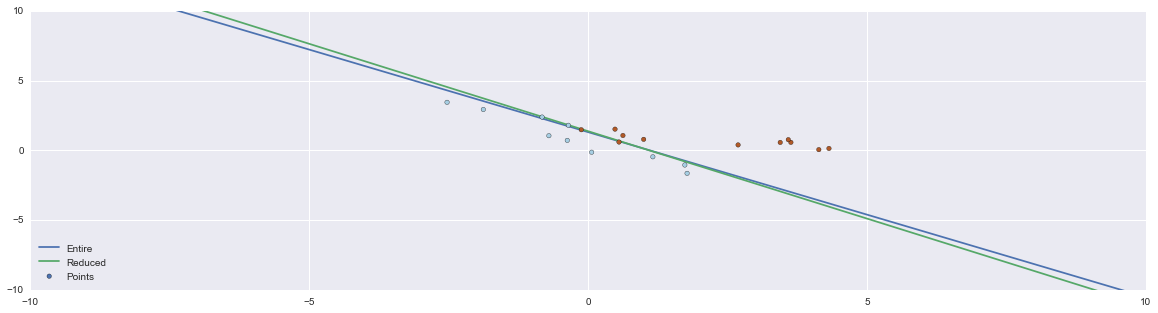

In [162]:
# now just show the points that are not in the majority 
sets = ((0.309, 0.79027), (0.5,1))
(reducedX, reducedY) = screen.filter(X,Y, min=sets[0][0], max=sets[0][1])

# train svm on the entire data
entire = svm.SVC(kernel='linear', C=1.0)
entire.fit(X,Y)  

plt.scatter(reducedX[:, 0], reducedX[:, 1], c=reducedY, zorder=10, cmap=plt.cm.Paired, label='Points', vmin=0, vmax=1)

reduced = svm.SVC(kernel='linear', C=1.0)#LinearSVC(C=1)#kernel='linear')
reduced.fit(reducedX, reducedY)
s = reduced.score(X,Y)
print "Taking only points from %f -> %f (in total %d), yields accuracy %f" % (sets[0][0], sets[0][1], reducedX.shape[0], s)
plotHyperplane(entire.coef_[0],entire.intercept_[0],plt=plt,label='Entire')        
plotHyperplane(reduced.coef_[0],reduced.intercept_[0],plt=plt,label='Reduced')        
plt.xlim([-10,10])
plt.ylim([-10,10])     
plt.legend(loc='lower left')
plt.show()


Our Method lambda 0.01   0.975000 with 14 points
Our Method lambda    1   0.965000 with 14 points
Our Method lambda   20   0.965000 with 14 points
Our Method lambda  100   0.960000 with 14 points
Entire Dataset  0.980000 with 200 points (14 sv)


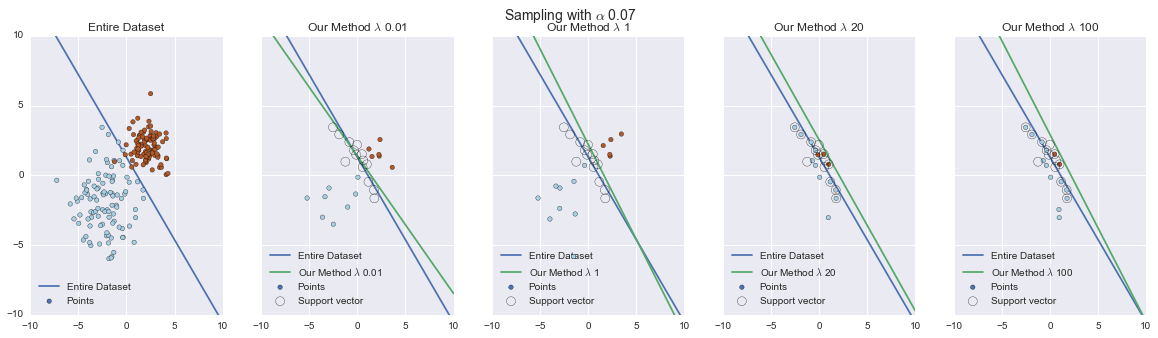

In [163]:
screen.display(X,Y,0.07)

Our Method lambda 0.01   0.975000 with 20 points
Our Method lambda    1   0.970000 with 20 points
Our Method lambda   20   0.975000 with 20 points
Our Method lambda  100   0.985000 with 20 points
Entire Dataset  0.980000 with 200 points (14 sv)


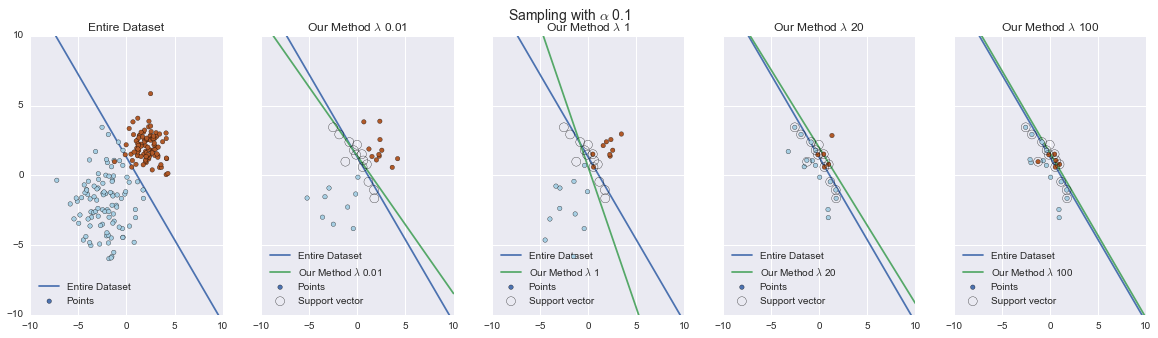

In [164]:
screen.display(X,Y,0.1)

Our Method lambda 0.01   0.975000 with 40 points
Our Method lambda    1   0.975000 with 40 points
Our Method lambda   20   0.980000 with 40 points
Our Method lambda  100   0.980000 with 40 points
Entire Dataset  0.980000 with 200 points (14 sv)


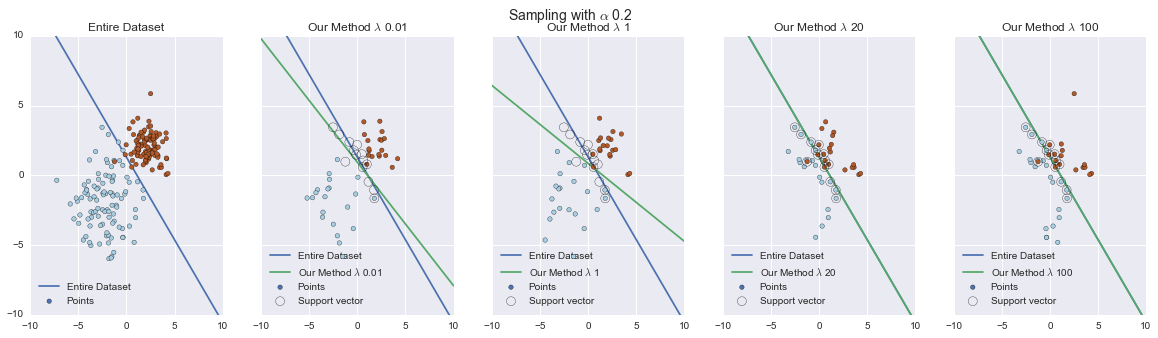

In [165]:
screen.display(X,Y,0.2)

Our Method lambda 0.01   0.970000 with 60 points
Our Method lambda    1   0.970000 with 60 points
Our Method lambda   20   0.980000 with 60 points
Our Method lambda  100   0.980000 with 60 points
Entire Dataset  0.980000 with 200 points (14 sv)


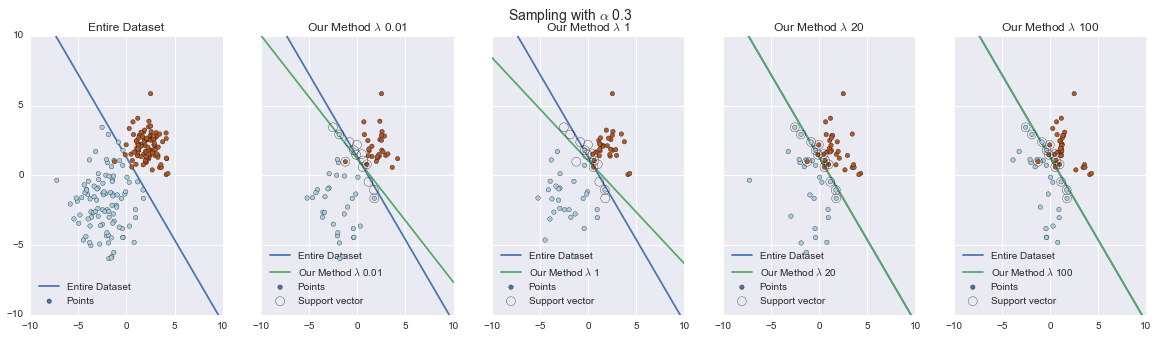

In [166]:
screen.display(X,Y,0.3)

Our Method lambda 0.01   0.980000 with 100 points
Our Method lambda    1   0.980000 with 100 points
Our Method lambda   20   0.980000 with 100 points
Our Method lambda  100   0.980000 with 100 points
Entire Dataset  0.980000 with 200 points (14 sv)


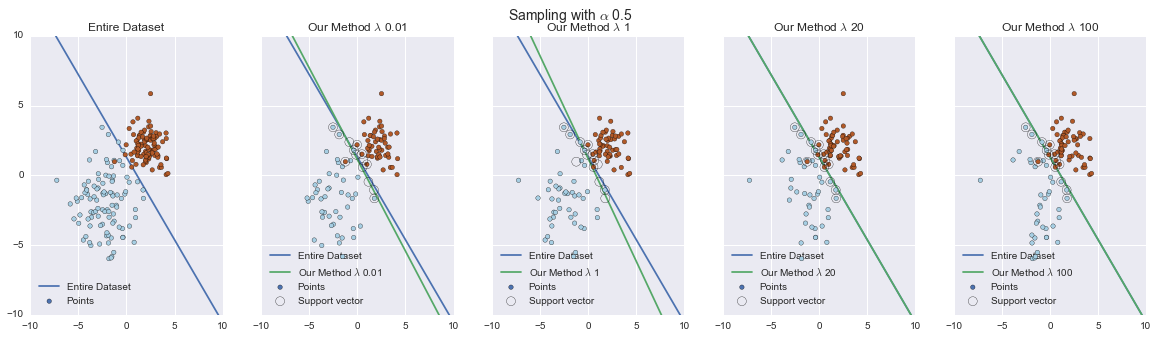

In [167]:
screen.display(X,Y,0.5)